0    420
1    420
Name: sentiment, dtype: int64
학습 데이터셋 정확도: 0.927
테스트 데이터셋 정확도: 0.752
[0.16635357 0.         0.10536875 0.05989751 0.12651041 0.08691218
 0.11121928 0.01138682 0.0120705  0.0169421  0.         0.
 0.00969631 0.01347145 0.         0.         0.01919561 0.03530927
 0.01799226 0.01961136 0.01419106 0.00826882]
['Game_Runtime' 'Phase' 'Hunger_PLAYER' 'Health_PLAYER' 'Sanity_PLAYER'
 'Player_Xloc' 'Player_Zloc' 'Curr_Inv_Cnt_PLAYER' 'Distance' 'log_P'
 'rock_P' 'grass_P']
AUC: 0.8434058717746661
Accuracy: 0.769
Precision: 0.480
Recall: 0.821
F1-score: 0.606


<Figure size 2880x2880 with 0 Axes>

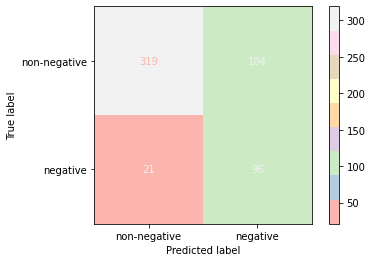

In [4]:
#KOR1sec - feature selection(2) - under sampling(1/3) + SMOTE
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
import warnings; warnings.filterwarnings(action='ignore') # 경고 메시지 무시
import matplotlib.pyplot as plt # 데이터 시각화 라이브러리
import pickle # 객체 입출력을 위한 라이브러리
from sklearn.model_selection import train_test_split # 훈련 데이터, 테스트 데이터 분리
from sklearn.preprocessing import StandardScaler # 정규화
from sklearn.ensemble import RandomForestClassifier as RFC # 랜덤포레스트 분류 알고리즘
from sklearn.tree import DecisionTreeClassifier as DTC # 의사결정나무 분류 알고리즘
from sklearn.ensemble import GradientBoostingClassifier as GBC # 그래디언트 부스팅 분류 알고리즘
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_moons
from sklearn.feature_selection import SelectFromModel
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from numpy import array 
########################

UnderSampling = 1       # 1 : undersampling(size->1/3), 2 : undersampling(size->minority),   0 : not undersampling    
OverSampling = 1        # 1 : oversampling(SMOTE),                                           0 : not oversampling
selection = 2           # 1 : feature selection - RFEVC, 2 : feature selection - mutual information, 0 : not feature selection
feat_start=1
########################
data = pd.read_csv('/Users/jun/Data/sentiment analysis - KOR/5초전데이터/sentiment+gamedata/KOR-1sec(fin).csv')
scaler = StandardScaler()
y = data['sentiment']
X = data.drop(labels=['sentiment','file','time'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,random_state=7)
# 설명변수 데이터 스케일링
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
feature_name = X.columns
if UnderSampling == 1:
    undersample = RandomUnderSampler(sampling_strategy=0.837) 
    X_train, y_train = undersample.fit_resample(X_train, y_train)
elif UnderSampling == 2:
    undersample = RandomUnderSampler(sampling_strategy='majority') 
    X_train, y_train = undersample.fit_resample(X_train, y_train)
    
if OverSampling == 1:
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)
    
    
print(y_train.value_counts())

def modeling_uncustomized (algorithm, X_train, y_train, X_test, y_test):
    # 하이퍼파라미터 조정 없이 모델 학습
    uncustomized = algorithm(random_state=1234)
    uncustomized.fit(X_train, y_train)
    # Train Data 설명력
    train_score_before = uncustomized.score(X_train, y_train).round(3)
    print(f"학습 데이터셋 정확도: {train_score_before}")
    # Test Data 설명력
    test_score_before = uncustomized.score(X_test, y_test).round(3)
    print(f"테스트 데이터셋 정확도: {test_score_before}")
    return train_score_before, test_score_before


def optimi_visualization(algorithm_name, X_values, train_score, test_score, xlabel, filename):
    # 하이퍼파라미터 조정에 따른 학습 데이터셋 기반 모델 성능 추이 시각화
    plt.plot(X_values, train_score, linestyle = '-', label = 'train score')
    # 하이퍼파라미터 조정에 따른 테스트 데이터셋 기반 모델 성능 추이 시각화
    plt.plot(X_values, test_score, linestyle = '--', label = 'test score')
    plt.ylabel('Accuracy(%)') # y축 라벨
    plt.xlabel(xlabel) # x축 라벨
    plt.legend() # 범례표시
    
def optimi_estimator(algorithm, algorithm_name, X_train, y_train, X_test, y_test, n_estimator_min, n_estimator_max):
    train_score = []; test_score =[]
    para_n_tree = [n_tree*5 for n_tree in range(n_estimator_min, n_estimator_max)]

    for v_n_estimators in para_n_tree:
        model = algorithm(n_estimators = v_n_estimators, random_state=1234)
        model.fit(X_train, y_train)
        train_score.append(model.score(X_train, y_train))
        test_score.append(model.score(X_test, y_test))

    # 트리 개수에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'n_estimators': para_n_tree, 'TrainScore': train_score, 'TestScore': test_score})
    # 트리 개수에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_n_tree, train_score, test_score, "The number of estimator", "n_estimator")
    print(round(df_score_n, 4))


def optimi_maxdepth (algorithm, algorithm_name, X_train, y_train, X_test, y_test, depth_min, depth_max, n_estimator):
    train_score = []; test_score = []
    para_depth = [depth for depth in range(depth_min, depth_max)]

    for v_max_depth in para_depth:
        # 의사결정나무 모델의 경우 트리 개수를 따로 설정하지 않기 때문에 RFC, GBC와 분리하여 모델링
        if algorithm == DTC:
            model = algorithm(max_depth = v_max_depth,
                              random_state=1234)
        else:
            model = algorithm(max_depth = v_max_depth,
                              n_estimators = n_estimator,
                              random_state=1234)
        
        model.fit(X_train, y_train)
        train_score.append(model.score(X_train, y_train))
        test_score.append(model.score(X_test, y_test))

    # 최대 깊이에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'depth': para_depth, 'TrainScore': train_score, 'TestScore': test_score})
    # 최대 깊이에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_depth, train_score, test_score, "The number of depth", "n_depth")
    print(round(df_score_n, 4))
    
def optimi_minsplit (algorithm, algorithm_name, X_train, y_train, X_test, y_test, n_split_min, n_split_max, n_estimator, n_depth):
    train_score = []; test_score = []
    para_split = [n_split*2 for n_split in range(n_split_min, n_split_max)]
    for v_min_samples_split in para_split:
        # 의사결정나무 모델의 경우 트리 개수를 따로 설정하지 않기 때문에 RFC, GBC와 분리하여 모델링
        if algorithm == DTC:
            model = algorithm(min_samples_split = v_min_samples_split,
                              max_depth = n_depth,
                              random_state = 1234)
        else:
            model = algorithm(min_samples_split = v_min_samples_split,
                              n_estimators = n_estimator,
                              max_depth = n_depth,
                              random_state = 1234)
        model.fit(X_train, y_train)
        train_score.append(model.score(X_train, y_train))
        test_score.append(model.score(X_test, y_test))

    # 분리 노드의 최소 자료 수에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'min_samples_split': para_split, 'TrainScore': train_score, 'TestScore': test_score})
    # 분리 노드의 최소 자료 수에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_split, train_score, test_score, "The minimum number of samples required to split an internal node", "min_samples_split")
    print(round(df_score_n, 4))
    
def optimi_minleaf(algorithm, algorithm_name, X_train, y_train, X_test, y_test, n_leaf_min, n_leaf_max, n_estimator, n_depth, n_split):
    train_score = []; test_score = []
    para_leaf = [n_leaf*2 for n_leaf in range(n_leaf_min, n_leaf_max)]

    for v_min_samples_leaf in para_leaf:
        # 의사결정나무 모델의 경우 트리 개수를 따로 설정하지 않기 때문에 RFC, GBC와 분리하여 모델링
        if algorithm == DTC:
            model = algorithm(min_samples_leaf = v_min_samples_leaf,
                                        max_depth = n_depth,
                                        min_samples_split = n_split,
                                        random_state=1234)
        else:
            model = algorithm(min_samples_leaf = v_min_samples_leaf,
                                n_estimators = n_estimator,
                                max_depth = n_depth,
                                min_samples_split = n_split,
                                random_state=1234)
        model.fit(X_train, y_train)
        train_score.append(model.score(X_train, y_train))
        test_score.append(model.score(X_test, y_test))

    # 잎사귀 노드의 최소 자료 수에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'min_samples_leaf': para_leaf, 'TrainScore': train_score, 'TestScore': test_score})
    # 잎사귀 노드의 최소 자료 수에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_leaf, train_score, test_score, "The minimum number of samples required to be at a leaf node", "min_samples_leaf")
    print(round(df_score_n, 4))
    
def model_final(algorithm, algorithm_name, feature_name, X_train, y_train, X_test, y_test, n_estimator, n_depth, n_split, n_leaf, selection):
    # 의사결정나무 모델의 경우 트리 개수를 따로 설정하지 않기 때문에 RFC, GBC와 분리하여 모델링
    if algorithm == DTC:
        model = algorithm(random_state=1234, 
                          min_samples_leaf = n_leaf,
                          min_samples_split = n_split, 
                          max_depth = n_depth)
    else:
        model = algorithm(random_state = 1234, 
                          n_estimators = n_estimator, 
                          min_samples_leaf = n_leaf,
                          min_samples_split = n_split, 
                          max_depth = n_depth)
    
    if selection == 1 :
        selector = RFECV(model, min_features_to_select=5, step=1, cv = 5)
        selector.fit(X_train, y_train)
        selected_columns = X.columns[selector.support_]

        print(selected_columns)
        train_acc = selector.score(X_train, y_train)
        test_acc = selector.score(X_test, y_test)
        y_pred = selector.predict(X_test)
        roc_auc = metrics.roc_auc_score(y_test, selector.predict_proba(X_test)[:,1])
        print('AUC: {}'.format(roc_auc))
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}") # 정확도
        print(f"Precision: {precision_score(y_test, y_pred):.3f}") # 정밀도
        print(f"Recall: {recall_score(y_test, y_pred):.3f}") # 재현율
        print(f"F1-score: {f1_score(y_test, y_pred):.3f}") # F1 스코어

        # 혼동행렬 시각화
#         plt.figure(figsize =(40, 40))
#         plot_confusion_matrix(model, X_test, y_test,include_values = True,display_labels = ['non-negative', 'negative'],cmap = 'Pastel1') # 컬러맵
#         plt.show()

        # 변수 중요도 산출
        dt_importance = pd.DataFrame()
        dt_importance['Feature'] = feature_name # 설명변수 이름
        dt_importance['Rank'] = selector.ranking_ # 설명변수 중요도 산출

        # 변수 중요도 내림차순 정렬
        dt_importance.sort_values("Rank", ascending = False, inplace = True)
        print(dt_importance.round(3))
        # 변수 중요도 오름차순 정렬
        dt_importance.sort_values("Rank", ascending = True, inplace = True)
        # 변수 중요도 시각화
        coordinates = range(len(dt_importance)) # 설명변수 개수만큼 bar 시각화
        plt.barh(y = coordinates, width = dt_importance["Rank"])
        plt.yticks(coordinates, dt_importance["Feature"]) # y축 눈금별 설명변수 이름 기입
        plt.xlabel("Feature Rank") # x축 이름
        plt.ylabel("Features") # y축 이름
    elif selection == 2:
        mi_score = mutual_info_classif(X,y)
        print(mi_score)
        selector = SelectKBest(mutual_info_classif, k=12)
        selector.fit(X_train, y_train)
        X_train = selector.transform(X_train)
        X_test = selector.transform(X_test)
        filter = selector.get_support()
        features = array(feature_name)
        print(features[filter])
        model.fit(X_train, y_train)
        
        score=selector.scores_
        
        train_acc = model.score(X_train, y_train)
        test_acc = model.score(X_test, y_test)
        y_pred = model.predict(X_test)
        roc_auc = metrics.roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
        print('AUC: {}'.format(roc_auc))
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}") # 정확도
        print(f"Precision: {precision_score(y_test, y_pred):.3f}") # 정밀도
        print(f"Recall: {recall_score(y_test, y_pred):.3f}") # 재현율
        print(f"F1-score: {f1_score(y_test, y_pred):.3f}") # F1 스코어

        # 혼동행렬 시각화
        plt.figure(figsize =(40, 40))
        plot_confusion_matrix(model, X_test, y_test,include_values = True,display_labels = ['non-negative', 'negative'],cmap = 'Pastel1') # 컬러맵
        plt.show()
    else:
        model.fit(X_train, y_train)
    
    
        # 최종 모델의 성능 평가
        train_acc = model.score(X_train, y_train)
        test_acc = model.score(X_test, y_test)
        y_pred = model.predict(X_test)
        roc_auc = metrics.roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
        print('AUC: {}'.format(roc_auc))
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}") # 정확도
        print(f"Precision: {precision_score(y_test, y_pred):.3f}") # 정밀도
        print(f"Recall: {recall_score(y_test, y_pred):.3f}") # 재현율
        print(f"F1-score: {f1_score(y_test, y_pred):.3f}") # F1 스코어

        # 혼동행렬 시각화
        plt.figure(figsize =(40, 40))
        plot_confusion_matrix(model, X_test, y_test,include_values = True,display_labels = ['non-negative', 'negative'],cmap = 'Pastel1') # 컬러맵
        plt.show()

        # 변수 중요도 산출
        dt_importance = pd.DataFrame()
        dt_importance['Feature'] = feature_name # 설명변수 이름
        dt_importance['Importance'] = model.feature_importances_ # 설명변수 중요도 산출

        # 변수 중요도 내림차순 정렬
        dt_importance.sort_values("Importance", ascending = False, inplace = True)
        print(dt_importance.round(3))
        # 변수 중요도 오름차순 정렬
        dt_importance.sort_values("Importance", ascending = True, inplace = True)
        # 변수 중요도 시각화
        coordinates = range(len(dt_importance)) # 설명변수 개수만큼 bar 시각화
        plt.barh(y = coordinates, width = dt_importance["Importance"])
        plt.yticks(coordinates, dt_importance["Feature"]) # y축 눈금별 설명변수 이름 기입
        plt.xlabel("Feature Importance") # x축 이름
        plt.ylabel("Features") # y축 이름
        
    

algorithm = GBC
algorithm_name = 'gbc'
train_acc_before, test_acc_before = modeling_uncustomized(algorithm, 
                                                          X_train,
                                                          y_train,
                                                          X_test,
                                                          y_test)

n_estimator = 100
n_depth = 7
n_split = 88
n_leaf = 6

model_final(algorithm, algorithm_name, feature_name,
            X_train, y_train, X_test, y_test,
            n_estimator, n_depth, n_split, n_leaf,selection)

0    1491
1    1491
Name: sentiment, dtype: int64
학습 데이터셋 정확도: 0.906
테스트 데이터셋 정확도: 0.824
[0.04033906 0.00072467 0.02037881 0.0147187  0.03529955 0.04248558
 0.04562292 0.00177919 0.         0.00334118 0.002213   0.00697372
 0.         0.00102239 0.00397896 0.00098542 0.02118933 0.
 0.00017091 0.00420651 0.         0.01103305]
['Game_Runtime' 'Phase' 'Health_PLAYER' 'Sanity_PLAYER' 'Player_Xloc'
 'Player_Zloc' 'Curr_Inv_Cnt_PLAYER' 'Curr_Equip_Hands_PLAYER' 'log_P'
 'grass_P' 'twig_P' 'flint_P']
AUC: 0.8650964611196592
Accuracy: 0.923
Precision: 0.389
Recall: 0.765
F1-score: 0.516


<Figure size 2880x2880 with 0 Axes>

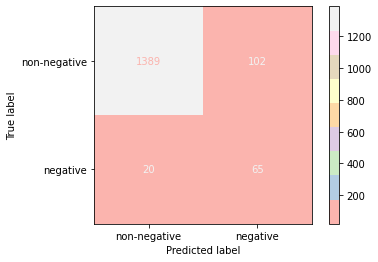

In [5]:
#ENG 1sec - feature selection(2) - under sampling(1/3) + SMOTE
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
import warnings; warnings.filterwarnings(action='ignore') # 경고 메시지 무시
import matplotlib.pyplot as plt # 데이터 시각화 라이브러리
import pickle # 객체 입출력을 위한 라이브러리
from sklearn.model_selection import train_test_split # 훈련 데이터, 테스트 데이터 분리
from sklearn.preprocessing import StandardScaler # 정규화
from sklearn.ensemble import RandomForestClassifier as RFC # 랜덤포레스트 분류 알고리즘
from sklearn.tree import DecisionTreeClassifier as DTC # 의사결정나무 분류 알고리즘
from sklearn.ensemble import GradientBoostingClassifier as GBC # 그래디언트 부스팅 분류 알고리즘
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_moons
from sklearn.feature_selection import SelectFromModel
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from numpy import array 
########################

UnderSampling = 1       # 1 : undersampling(size->1/3), 2 : undersampling(size->minority),   0 : not undersampling    
OverSampling = 1        # 1 : oversampling(SMOTE),                                           0 : not oversampling
selection = 2           # 1 : feature selection - RFEVC, 2 : feature selection - mutual information, 0 : not feature selection
feat_start=1
########################
data = pd.read_csv('/Users/jun/Data/sentiment analysis - ENG/5초전/사용할 파일/sentiment+gamedata/ENG-1sec(fin).csv')
scaler = StandardScaler()
y = data['sentiment']
X = data.drop(labels=['sentiment','file','time'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,random_state=7)
# 설명변수 데이터 스케일링
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
feature_name = X.columns
if UnderSampling == 1:
    undersample = RandomUnderSampler(sampling_strategy=0.1703) 
    X_train, y_train = undersample.fit_resample(X_train, y_train)
elif UnderSampling == 2:
    undersample = RandomUnderSampler(sampling_strategy='majority') 
    X_train, y_train = undersample.fit_resample(X_train, y_train)
    
if OverSampling == 1:
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)
    
    
print(y_train.value_counts())

def modeling_uncustomized (algorithm, X_train, y_train, X_test, y_test):
    # 하이퍼파라미터 조정 없이 모델 학습
    uncustomized = algorithm(random_state=1234)
    uncustomized.fit(X_train, y_train)
    # Train Data 설명력
    train_score_before = uncustomized.score(X_train, y_train).round(3)
    print(f"학습 데이터셋 정확도: {train_score_before}")
    # Test Data 설명력
    test_score_before = uncustomized.score(X_test, y_test).round(3)
    print(f"테스트 데이터셋 정확도: {test_score_before}")
    return train_score_before, test_score_before


def optimi_visualization(algorithm_name, X_values, train_score, test_score, xlabel, filename):
    # 하이퍼파라미터 조정에 따른 학습 데이터셋 기반 모델 성능 추이 시각화
    plt.plot(X_values, train_score, linestyle = '-', label = 'train score')
    # 하이퍼파라미터 조정에 따른 테스트 데이터셋 기반 모델 성능 추이 시각화
    plt.plot(X_values, test_score, linestyle = '--', label = 'test score')
    plt.ylabel('Accuracy(%)') # y축 라벨
    plt.xlabel(xlabel) # x축 라벨
    plt.legend() # 범례표시
    
def optimi_estimator(algorithm, algorithm_name, X_train, y_train, X_test, y_test, n_estimator_min, n_estimator_max):
    train_score = []; test_score =[]
    para_n_tree = [n_tree*5 for n_tree in range(n_estimator_min, n_estimator_max)]

    for v_n_estimators in para_n_tree:
        model = algorithm(n_estimators = v_n_estimators, random_state=1234)
        model.fit(X_train, y_train)
        train_score.append(model.score(X_train, y_train))
        test_score.append(model.score(X_test, y_test))

    # 트리 개수에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'n_estimators': para_n_tree, 'TrainScore': train_score, 'TestScore': test_score})
    # 트리 개수에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_n_tree, train_score, test_score, "The number of estimator", "n_estimator")
    print(round(df_score_n, 4))


def optimi_maxdepth (algorithm, algorithm_name, X_train, y_train, X_test, y_test, depth_min, depth_max, n_estimator):
    train_score = []; test_score = []
    para_depth = [depth for depth in range(depth_min, depth_max)]

    for v_max_depth in para_depth:
        # 의사결정나무 모델의 경우 트리 개수를 따로 설정하지 않기 때문에 RFC, GBC와 분리하여 모델링
        if algorithm == DTC:
            model = algorithm(max_depth = v_max_depth,
                              random_state=1234)
        else:
            model = algorithm(max_depth = v_max_depth,
                              n_estimators = n_estimator,
                              random_state=1234)
        
        model.fit(X_train, y_train)
        train_score.append(model.score(X_train, y_train))
        test_score.append(model.score(X_test, y_test))

    # 최대 깊이에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'depth': para_depth, 'TrainScore': train_score, 'TestScore': test_score})
    # 최대 깊이에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_depth, train_score, test_score, "The number of depth", "n_depth")
    print(round(df_score_n, 4))
    
def optimi_minsplit (algorithm, algorithm_name, X_train, y_train, X_test, y_test, n_split_min, n_split_max, n_estimator, n_depth):
    train_score = []; test_score = []
    para_split = [n_split*2 for n_split in range(n_split_min, n_split_max)]
    for v_min_samples_split in para_split:
        # 의사결정나무 모델의 경우 트리 개수를 따로 설정하지 않기 때문에 RFC, GBC와 분리하여 모델링
        if algorithm == DTC:
            model = algorithm(min_samples_split = v_min_samples_split,
                              max_depth = n_depth,
                              random_state = 1234)
        else:
            model = algorithm(min_samples_split = v_min_samples_split,
                              n_estimators = n_estimator,
                              max_depth = n_depth,
                              random_state = 1234)
        model.fit(X_train, y_train)
        train_score.append(model.score(X_train, y_train))
        test_score.append(model.score(X_test, y_test))

    # 분리 노드의 최소 자료 수에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'min_samples_split': para_split, 'TrainScore': train_score, 'TestScore': test_score})
    # 분리 노드의 최소 자료 수에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_split, train_score, test_score, "The minimum number of samples required to split an internal node", "min_samples_split")
    print(round(df_score_n, 4))
    
def optimi_minleaf(algorithm, algorithm_name, X_train, y_train, X_test, y_test, n_leaf_min, n_leaf_max, n_estimator, n_depth, n_split):
    train_score = []; test_score = []
    para_leaf = [n_leaf*2 for n_leaf in range(n_leaf_min, n_leaf_max)]

    for v_min_samples_leaf in para_leaf:
        # 의사결정나무 모델의 경우 트리 개수를 따로 설정하지 않기 때문에 RFC, GBC와 분리하여 모델링
        if algorithm == DTC:
            model = algorithm(min_samples_leaf = v_min_samples_leaf,
                                        max_depth = n_depth,
                                        min_samples_split = n_split,
                                        random_state=1234)
        else:
            model = algorithm(min_samples_leaf = v_min_samples_leaf,
                                n_estimators = n_estimator,
                                max_depth = n_depth,
                                min_samples_split = n_split,
                                random_state=1234)
        model.fit(X_train, y_train)
        train_score.append(model.score(X_train, y_train))
        test_score.append(model.score(X_test, y_test))

    # 잎사귀 노드의 최소 자료 수에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'min_samples_leaf': para_leaf, 'TrainScore': train_score, 'TestScore': test_score})
    # 잎사귀 노드의 최소 자료 수에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_leaf, train_score, test_score, "The minimum number of samples required to be at a leaf node", "min_samples_leaf")
    print(round(df_score_n, 4))
    
def model_final(algorithm, algorithm_name, feature_name, X_train, y_train, X_test, y_test, n_estimator, n_depth, n_split, n_leaf, selection):
    # 의사결정나무 모델의 경우 트리 개수를 따로 설정하지 않기 때문에 RFC, GBC와 분리하여 모델링
    if algorithm == DTC:
        model = algorithm(random_state=1234, 
                          min_samples_leaf = n_leaf,
                          min_samples_split = n_split, 
                          max_depth = n_depth)
    else:
        model = algorithm(random_state = 1234, 
                          n_estimators = n_estimator, 
                          min_samples_leaf = n_leaf,
                          min_samples_split = n_split, 
                          max_depth = n_depth)
    
    if selection == 1 :
        selector = RFECV(model, min_features_to_select=5, step=1, cv = 5)
        selector.fit(X_train, y_train)
        selected_columns = X.columns[selector.support_]

        print(selected_columns)
        train_acc = selector.score(X_train, y_train)
        test_acc = selector.score(X_test, y_test)
        y_pred = selector.predict(X_test)
        roc_auc = metrics.roc_auc_score(y_test, selector.predict_proba(X_test)[:,1])
        print('AUC: {}'.format(roc_auc))
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}") # 정확도
        print(f"Precision: {precision_score(y_test, y_pred):.3f}") # 정밀도
        print(f"Recall: {recall_score(y_test, y_pred):.3f}") # 재현율
        print(f"F1-score: {f1_score(y_test, y_pred):.3f}") # F1 스코어

        # 혼동행렬 시각화
#         plt.figure(figsize =(40, 40))
#         plot_confusion_matrix(model, X_test, y_test,include_values = True,display_labels = ['non-negative', 'negative'],cmap = 'Pastel1') # 컬러맵
#         plt.show()

        # 변수 중요도 산출
        dt_importance = pd.DataFrame()
        dt_importance['Feature'] = feature_name # 설명변수 이름
        dt_importance['Rank'] = selector.ranking_ # 설명변수 중요도 산출

        # 변수 중요도 내림차순 정렬
        dt_importance.sort_values("Rank", ascending = False, inplace = True)
        print(dt_importance.round(3))
        # 변수 중요도 오름차순 정렬
        dt_importance.sort_values("Rank", ascending = True, inplace = True)
        # 변수 중요도 시각화
        coordinates = range(len(dt_importance)) # 설명변수 개수만큼 bar 시각화
        plt.barh(y = coordinates, width = dt_importance["Rank"])
        plt.yticks(coordinates, dt_importance["Feature"]) # y축 눈금별 설명변수 이름 기입
        plt.xlabel("Feature Rank") # x축 이름
        plt.ylabel("Features") # y축 이름
    elif selection == 2:
        mi_score = mutual_info_classif(X,y)
        print(mi_score)
        selector = SelectKBest(mutual_info_classif, k=12)
        selector.fit(X_train, y_train)
        X_train = selector.transform(X_train)
        X_test = selector.transform(X_test)
        filter = selector.get_support()
        features = array(feature_name)
        print(features[filter])
        model.fit(X_train, y_train)
        
        score=selector.scores_
        
        train_acc = model.score(X_train, y_train)
        test_acc = model.score(X_test, y_test)
        y_pred = model.predict(X_test)
        roc_auc = metrics.roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
        print('AUC: {}'.format(roc_auc))
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}") # 정확도
        print(f"Precision: {precision_score(y_test, y_pred):.3f}") # 정밀도
        print(f"Recall: {recall_score(y_test, y_pred):.3f}") # 재현율
        print(f"F1-score: {f1_score(y_test, y_pred):.3f}") # F1 스코어

        # 혼동행렬 시각화
        plt.figure(figsize =(40, 40))
        plot_confusion_matrix(model, X_test, y_test,include_values = True,display_labels = ['non-negative', 'negative'],cmap = 'Pastel1') # 컬러맵
        plt.show()
    else:
        model.fit(X_train, y_train)
    
    
        # 최종 모델의 성능 평가
        train_acc = model.score(X_train, y_train)
        test_acc = model.score(X_test, y_test)
        y_pred = model.predict(X_test)
        roc_auc = metrics.roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
        print('AUC: {}'.format(roc_auc))
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}") # 정확도
        print(f"Precision: {precision_score(y_test, y_pred):.3f}") # 정밀도
        print(f"Recall: {recall_score(y_test, y_pred):.3f}") # 재현율
        print(f"F1-score: {f1_score(y_test, y_pred):.3f}") # F1 스코어

        # 혼동행렬 시각화
        plt.figure(figsize =(40, 40))
        plot_confusion_matrix(model, X_test, y_test,include_values = True,display_labels = ['non-negative', 'negative'],cmap = 'Pastel1') # 컬러맵
        plt.show()

        # 변수 중요도 산출
        dt_importance = pd.DataFrame()
        dt_importance['Feature'] = feature_name # 설명변수 이름
        dt_importance['Importance'] = model.feature_importances_ # 설명변수 중요도 산출

        # 변수 중요도 내림차순 정렬
        dt_importance.sort_values("Importance", ascending = False, inplace = True)
        print(dt_importance.round(3))
        # 변수 중요도 오름차순 정렬
        dt_importance.sort_values("Importance", ascending = True, inplace = True)
        # 변수 중요도 시각화
        coordinates = range(len(dt_importance)) # 설명변수 개수만큼 bar 시각화
        plt.barh(y = coordinates, width = dt_importance["Importance"])
        plt.yticks(coordinates, dt_importance["Feature"]) # y축 눈금별 설명변수 이름 기입
        plt.xlabel("Feature Importance") # x축 이름
        plt.ylabel("Features") # y축 이름
        
    

algorithm = GBC
algorithm_name = 'gbc'
train_acc_before, test_acc_before = modeling_uncustomized(algorithm, 
                                                          X_train,
                                                          y_train,
                                                          X_test,
                                                          y_test)

n_estimator = 145
n_depth = 9
n_split = 22
n_leaf = 4

model_final(algorithm, algorithm_name, feature_name,
            X_train, y_train, X_test, y_test,
            n_estimator, n_depth, n_split, n_leaf,selection)

0    834
1    834
Name: sentiment, dtype: int64
학습 데이터셋 정확도: 0.872
테스트 데이터셋 정확도: 0.784
[0.18128336 0.00512499 0.08995579 0.09168819 0.18854404 0.16664706
 0.20219446 0.0109063  0.         0.00661828 0.00605652 0.01037725
 0.0020636  0.00070095 0.00704314 0.         0.04923145 0.01920274
 0.02738431 0.03954573 0.00585544 0.02861927]
['Game_Runtime' 'Hunger_PLAYER' 'Health_PLAYER' 'Sanity_PLAYER'
 'Player_Xloc' 'Player_Zloc' 'Curr_Equip_Hands_PLAYER' 'Distance' 'log_P'
 'grass_P' 'twig_P' 'flint_P']
AUC: 0.9725790274871575
Accuracy: 0.909
Precision: 0.716
Recall: 0.961
F1-score: 0.821


<Figure size 2880x2880 with 0 Axes>

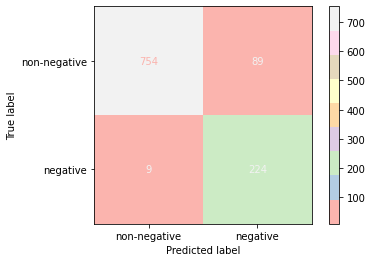

In [6]:
#KOR 3sec - feature selection(2) - under sampling(1/3) + SMOTE
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
import warnings; warnings.filterwarnings(action='ignore') # 경고 메시지 무시
import matplotlib.pyplot as plt # 데이터 시각화 라이브러리
import pickle # 객체 입출력을 위한 라이브러리
from sklearn.model_selection import train_test_split # 훈련 데이터, 테스트 데이터 분리
from sklearn.preprocessing import StandardScaler # 정규화
from sklearn.ensemble import RandomForestClassifier as RFC # 랜덤포레스트 분류 알고리즘
from sklearn.tree import DecisionTreeClassifier as DTC # 의사결정나무 분류 알고리즘
from sklearn.ensemble import GradientBoostingClassifier as GBC # 그래디언트 부스팅 분류 알고리즘
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_moons
from sklearn.feature_selection import SelectFromModel
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from numpy import array 
########################

UnderSampling = 1       # 1 : undersampling(size->1/3), 2 : undersampling(size->minority),   0 : not undersampling    
OverSampling = 1        # 1 : oversampling(SMOTE),                                           0 : not oversampling
selection = 2           # 1 : feature selection - RFEVC, 2 : feature selection - mutual information, 0 : not feature selection
feat_start=1
########################
data = pd.read_csv('/Users/jun/Data/sentiment analysis - KOR/5초전데이터/sentiment+gamedata/KOR-3sec(fin).csv')
scaler = StandardScaler()
y = data['sentiment']
X = data.drop(labels=['sentiment','file','time'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,random_state=7)
# 설명변수 데이터 스케일링
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
feature_name = X.columns
if UnderSampling == 1:
    undersample = RandomUnderSampler(sampling_strategy=0.836) 
    X_train, y_train = undersample.fit_resample(X_train, y_train)
elif UnderSampling == 2:
    undersample = RandomUnderSampler(sampling_strategy='majority') 
    X_train, y_train = undersample.fit_resample(X_train, y_train)
    
if OverSampling == 1:
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)
    
    
print(y_train.value_counts())

def modeling_uncustomized (algorithm, X_train, y_train, X_test, y_test):
    # 하이퍼파라미터 조정 없이 모델 학습
    uncustomized = algorithm(random_state=1234)
    uncustomized.fit(X_train, y_train)
    # Train Data 설명력
    train_score_before = uncustomized.score(X_train, y_train).round(3)
    print(f"학습 데이터셋 정확도: {train_score_before}")
    # Test Data 설명력
    test_score_before = uncustomized.score(X_test, y_test).round(3)
    print(f"테스트 데이터셋 정확도: {test_score_before}")
    return train_score_before, test_score_before


def optimi_visualization(algorithm_name, X_values, train_score, test_score, xlabel, filename):
    # 하이퍼파라미터 조정에 따른 학습 데이터셋 기반 모델 성능 추이 시각화
    plt.plot(X_values, train_score, linestyle = '-', label = 'train score')
    # 하이퍼파라미터 조정에 따른 테스트 데이터셋 기반 모델 성능 추이 시각화
    plt.plot(X_values, test_score, linestyle = '--', label = 'test score')
    plt.ylabel('Accuracy(%)') # y축 라벨
    plt.xlabel(xlabel) # x축 라벨
    plt.legend() # 범례표시
    
def optimi_estimator(algorithm, algorithm_name, X_train, y_train, X_test, y_test, n_estimator_min, n_estimator_max):
    train_score = []; test_score =[]
    para_n_tree = [n_tree*5 for n_tree in range(n_estimator_min, n_estimator_max)]

    for v_n_estimators in para_n_tree:
        model = algorithm(n_estimators = v_n_estimators, random_state=1234)
        model.fit(X_train, y_train)
        train_score.append(model.score(X_train, y_train))
        test_score.append(model.score(X_test, y_test))

    # 트리 개수에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'n_estimators': para_n_tree, 'TrainScore': train_score, 'TestScore': test_score})
    # 트리 개수에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_n_tree, train_score, test_score, "The number of estimator", "n_estimator")
    print(round(df_score_n, 4))


def optimi_maxdepth (algorithm, algorithm_name, X_train, y_train, X_test, y_test, depth_min, depth_max, n_estimator):
    train_score = []; test_score = []
    para_depth = [depth for depth in range(depth_min, depth_max)]

    for v_max_depth in para_depth:
        # 의사결정나무 모델의 경우 트리 개수를 따로 설정하지 않기 때문에 RFC, GBC와 분리하여 모델링
        if algorithm == DTC:
            model = algorithm(max_depth = v_max_depth,
                              random_state=1234)
        else:
            model = algorithm(max_depth = v_max_depth,
                              n_estimators = n_estimator,
                              random_state=1234)
        
        model.fit(X_train, y_train)
        train_score.append(model.score(X_train, y_train))
        test_score.append(model.score(X_test, y_test))

    # 최대 깊이에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'depth': para_depth, 'TrainScore': train_score, 'TestScore': test_score})
    # 최대 깊이에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_depth, train_score, test_score, "The number of depth", "n_depth")
    print(round(df_score_n, 4))
    
def optimi_minsplit (algorithm, algorithm_name, X_train, y_train, X_test, y_test, n_split_min, n_split_max, n_estimator, n_depth):
    train_score = []; test_score = []
    para_split = [n_split*2 for n_split in range(n_split_min, n_split_max)]
    for v_min_samples_split in para_split:
        # 의사결정나무 모델의 경우 트리 개수를 따로 설정하지 않기 때문에 RFC, GBC와 분리하여 모델링
        if algorithm == DTC:
            model = algorithm(min_samples_split = v_min_samples_split,
                              max_depth = n_depth,
                              random_state = 1234)
        else:
            model = algorithm(min_samples_split = v_min_samples_split,
                              n_estimators = n_estimator,
                              max_depth = n_depth,
                              random_state = 1234)
        model.fit(X_train, y_train)
        train_score.append(model.score(X_train, y_train))
        test_score.append(model.score(X_test, y_test))

    # 분리 노드의 최소 자료 수에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'min_samples_split': para_split, 'TrainScore': train_score, 'TestScore': test_score})
    # 분리 노드의 최소 자료 수에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_split, train_score, test_score, "The minimum number of samples required to split an internal node", "min_samples_split")
    print(round(df_score_n, 4))
    
def optimi_minleaf(algorithm, algorithm_name, X_train, y_train, X_test, y_test, n_leaf_min, n_leaf_max, n_estimator, n_depth, n_split):
    train_score = []; test_score = []
    para_leaf = [n_leaf*2 for n_leaf in range(n_leaf_min, n_leaf_max)]

    for v_min_samples_leaf in para_leaf:
        # 의사결정나무 모델의 경우 트리 개수를 따로 설정하지 않기 때문에 RFC, GBC와 분리하여 모델링
        if algorithm == DTC:
            model = algorithm(min_samples_leaf = v_min_samples_leaf,
                                        max_depth = n_depth,
                                        min_samples_split = n_split,
                                        random_state=1234)
        else:
            model = algorithm(min_samples_leaf = v_min_samples_leaf,
                                n_estimators = n_estimator,
                                max_depth = n_depth,
                                min_samples_split = n_split,
                                random_state=1234)
        model.fit(X_train, y_train)
        train_score.append(model.score(X_train, y_train))
        test_score.append(model.score(X_test, y_test))

    # 잎사귀 노드의 최소 자료 수에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'min_samples_leaf': para_leaf, 'TrainScore': train_score, 'TestScore': test_score})
    # 잎사귀 노드의 최소 자료 수에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_leaf, train_score, test_score, "The minimum number of samples required to be at a leaf node", "min_samples_leaf")
    print(round(df_score_n, 4))
    
def model_final(algorithm, algorithm_name, feature_name, X_train, y_train, X_test, y_test, n_estimator, n_depth, n_split, n_leaf, selection):
    # 의사결정나무 모델의 경우 트리 개수를 따로 설정하지 않기 때문에 RFC, GBC와 분리하여 모델링
    if algorithm == DTC:
        model = algorithm(random_state=1234, 
                          min_samples_leaf = n_leaf,
                          min_samples_split = n_split, 
                          max_depth = n_depth)
    else:
        model = algorithm(random_state = 1234, 
                          n_estimators = n_estimator, 
                          min_samples_leaf = n_leaf,
                          min_samples_split = n_split, 
                          max_depth = n_depth)
    
    if selection == 1 :
        selector = RFECV(model, min_features_to_select=5, step=1, cv = 5)
        selector.fit(X_train, y_train)
        selected_columns = X.columns[selector.support_]

        print(selected_columns)
        train_acc = selector.score(X_train, y_train)
        test_acc = selector.score(X_test, y_test)
        y_pred = selector.predict(X_test)
        roc_auc = metrics.roc_auc_score(y_test, selector.predict_proba(X_test)[:,1])
        print('AUC: {}'.format(roc_auc))
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}") # 정확도
        print(f"Precision: {precision_score(y_test, y_pred):.3f}") # 정밀도
        print(f"Recall: {recall_score(y_test, y_pred):.3f}") # 재현율
        print(f"F1-score: {f1_score(y_test, y_pred):.3f}") # F1 스코어

        # 혼동행렬 시각화
#         plt.figure(figsize =(40, 40))
#         plot_confusion_matrix(model, X_test, y_test,include_values = True,display_labels = ['non-negative', 'negative'],cmap = 'Pastel1') # 컬러맵
#         plt.show()

        # 변수 중요도 산출
        dt_importance = pd.DataFrame()
        dt_importance['Feature'] = feature_name # 설명변수 이름
        dt_importance['Rank'] = selector.ranking_ # 설명변수 중요도 산출

        # 변수 중요도 내림차순 정렬
        dt_importance.sort_values("Rank", ascending = False, inplace = True)
        print(dt_importance.round(3))
        # 변수 중요도 오름차순 정렬
        dt_importance.sort_values("Rank", ascending = True, inplace = True)
        # 변수 중요도 시각화
        coordinates = range(len(dt_importance)) # 설명변수 개수만큼 bar 시각화
        plt.barh(y = coordinates, width = dt_importance["Rank"])
        plt.yticks(coordinates, dt_importance["Feature"]) # y축 눈금별 설명변수 이름 기입
        plt.xlabel("Feature Rank") # x축 이름
        plt.ylabel("Features") # y축 이름
    elif selection == 2:
        mi_score = mutual_info_classif(X,y)
        print(mi_score)
        selector = SelectKBest(mutual_info_classif, k=12)
        selector.fit(X_train, y_train)
        X_train = selector.transform(X_train)
        X_test = selector.transform(X_test)
        filter = selector.get_support()
        features = array(feature_name)
        print(features[filter])
        model.fit(X_train, y_train)
        
        score=selector.scores_
        
        train_acc = model.score(X_train, y_train)
        test_acc = model.score(X_test, y_test)
        y_pred = model.predict(X_test)
        roc_auc = metrics.roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
        print('AUC: {}'.format(roc_auc))
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}") # 정확도
        print(f"Precision: {precision_score(y_test, y_pred):.3f}") # 정밀도
        print(f"Recall: {recall_score(y_test, y_pred):.3f}") # 재현율
        print(f"F1-score: {f1_score(y_test, y_pred):.3f}") # F1 스코어

        # 혼동행렬 시각화
        plt.figure(figsize =(40, 40))
        plot_confusion_matrix(model, X_test, y_test,include_values = True,display_labels = ['non-negative', 'negative'],cmap = 'Pastel1') # 컬러맵
        plt.show()
    else:
        model.fit(X_train, y_train)
    
    
        # 최종 모델의 성능 평가
        train_acc = model.score(X_train, y_train)
        test_acc = model.score(X_test, y_test)
        y_pred = model.predict(X_test)
        roc_auc = metrics.roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
        print('AUC: {}'.format(roc_auc))
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}") # 정확도
        print(f"Precision: {precision_score(y_test, y_pred):.3f}") # 정밀도
        print(f"Recall: {recall_score(y_test, y_pred):.3f}") # 재현율
        print(f"F1-score: {f1_score(y_test, y_pred):.3f}") # F1 스코어

        # 혼동행렬 시각화
        plt.figure(figsize =(40, 40))
        plot_confusion_matrix(model, X_test, y_test,include_values = True,display_labels = ['non-negative', 'negative'],cmap = 'Pastel1') # 컬러맵
        plt.show()

        # 변수 중요도 산출
        dt_importance = pd.DataFrame()
        dt_importance['Feature'] = feature_name # 설명변수 이름
        dt_importance['Importance'] = model.feature_importances_ # 설명변수 중요도 산출

        # 변수 중요도 내림차순 정렬
        dt_importance.sort_values("Importance", ascending = False, inplace = True)
        print(dt_importance.round(3))
        # 변수 중요도 오름차순 정렬
        dt_importance.sort_values("Importance", ascending = True, inplace = True)
        # 변수 중요도 시각화
        coordinates = range(len(dt_importance)) # 설명변수 개수만큼 bar 시각화
        plt.barh(y = coordinates, width = dt_importance["Importance"])
        plt.yticks(coordinates, dt_importance["Feature"]) # y축 눈금별 설명변수 이름 기입
        plt.xlabel("Feature Importance") # x축 이름
        plt.ylabel("Features") # y축 이름
        
    

algorithm = GBC
algorithm_name = 'gbc'
train_acc_before, test_acc_before = modeling_uncustomized(algorithm, 
                                                          X_train,
                                                          y_train,
                                                          X_test,
                                                          y_test)

n_estimator = 140
n_depth = 12
n_split = 24
n_leaf = 42

model_final(algorithm, algorithm_name, feature_name,
            X_train, y_train, X_test, y_test,
            n_estimator, n_depth, n_split, n_leaf,selection)

0    2977
1    2977
Name: sentiment, dtype: int64
학습 데이터셋 정확도: 0.871
테스트 데이터셋 정확도: 0.809
[0.05257941 0.00033085 0.02483902 0.02134086 0.05908079 0.07152617
 0.06545096 0.00374581 0.00154551 0.00014452 0.         0.00044384
 0.         0.0039329  0.00106184 0.         0.02031124 0.00234242
 0.00345484 0.00350704 0.00204696 0.00440261]
['Game_Runtime' 'Hunger_PLAYER' 'Health_PLAYER' 'Sanity_PLAYER'
 'Player_Xloc' 'Player_Zloc' 'Curr_Inv_Cnt_PLAYER' 'Distance' 'log_P'
 'grass_P' 'twig_P' 'flint_P']
AUC: 0.983238159220692
Accuracy: 0.955
Precision: 0.547
Recall: 0.929
F1-score: 0.688


<Figure size 2880x2880 with 0 Axes>

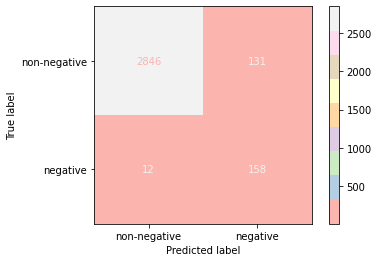

In [7]:
#ENG 3sec - feature selection(2) - under sampling(1/3) + SMOTE
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
import warnings; warnings.filterwarnings(action='ignore') # 경고 메시지 무시
import matplotlib.pyplot as plt # 데이터 시각화 라이브러리
import pickle # 객체 입출력을 위한 라이브러리
from sklearn.model_selection import train_test_split # 훈련 데이터, 테스트 데이터 분리
from sklearn.preprocessing import StandardScaler # 정규화
from sklearn.ensemble import RandomForestClassifier as RFC # 랜덤포레스트 분류 알고리즘
from sklearn.tree import DecisionTreeClassifier as DTC # 의사결정나무 분류 알고리즘
from sklearn.ensemble import GradientBoostingClassifier as GBC # 그래디언트 부스팅 분류 알고리즘
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_moons
from sklearn.feature_selection import SelectFromModel
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from numpy import array 
########################

UnderSampling = 1       # 1 : undersampling(size->1/3), 2 : undersampling(size->minority),   0 : not undersampling    
OverSampling = 1        # 1 : oversampling(SMOTE),                                           0 : not oversampling
selection = 2           # 1 : feature selection - RFEVC, 2 : feature selection - mutual information, 0 : not feature selection
feat_start=1
########################
data = pd.read_csv('/Users/jun/Data/sentiment analysis - ENG/5초전/사용할 파일/sentiment+gamedata/ENG-3sec(fin).csv')
scaler = StandardScaler()
y = data['sentiment']
X = data.drop(labels=['sentiment','file','time'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,random_state=7)
# 설명변수 데이터 스케일링
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
feature_name = X.columns
if UnderSampling == 1:
    undersample = RandomUnderSampler(sampling_strategy=0.17064) 
    X_train, y_train = undersample.fit_resample(X_train, y_train)
elif UnderSampling == 2:
    undersample = RandomUnderSampler(sampling_strategy='majority') 
    X_train, y_train = undersample.fit_resample(X_train, y_train)
    
if OverSampling == 1:
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)
    
    
print(y_train.value_counts())

def modeling_uncustomized (algorithm, X_train, y_train, X_test, y_test):
    # 하이퍼파라미터 조정 없이 모델 학습
    uncustomized = algorithm(random_state=1234)
    uncustomized.fit(X_train, y_train)
    # Train Data 설명력
    train_score_before = uncustomized.score(X_train, y_train).round(3)
    print(f"학습 데이터셋 정확도: {train_score_before}")
    # Test Data 설명력
    test_score_before = uncustomized.score(X_test, y_test).round(3)
    print(f"테스트 데이터셋 정확도: {test_score_before}")
    return train_score_before, test_score_before


def optimi_visualization(algorithm_name, X_values, train_score, test_score, xlabel, filename):
    # 하이퍼파라미터 조정에 따른 학습 데이터셋 기반 모델 성능 추이 시각화
    plt.plot(X_values, train_score, linestyle = '-', label = 'train score')
    # 하이퍼파라미터 조정에 따른 테스트 데이터셋 기반 모델 성능 추이 시각화
    plt.plot(X_values, test_score, linestyle = '--', label = 'test score')
    plt.ylabel('Accuracy(%)') # y축 라벨
    plt.xlabel(xlabel) # x축 라벨
    plt.legend() # 범례표시
    
def optimi_estimator(algorithm, algorithm_name, X_train, y_train, X_test, y_test, n_estimator_min, n_estimator_max):
    train_score = []; test_score =[]
    para_n_tree = [n_tree*5 for n_tree in range(n_estimator_min, n_estimator_max)]

    for v_n_estimators in para_n_tree:
        model = algorithm(n_estimators = v_n_estimators, random_state=1234)
        model.fit(X_train, y_train)
        train_score.append(model.score(X_train, y_train))
        test_score.append(model.score(X_test, y_test))

    # 트리 개수에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'n_estimators': para_n_tree, 'TrainScore': train_score, 'TestScore': test_score})
    # 트리 개수에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_n_tree, train_score, test_score, "The number of estimator", "n_estimator")
    print(round(df_score_n, 4))


def optimi_maxdepth (algorithm, algorithm_name, X_train, y_train, X_test, y_test, depth_min, depth_max, n_estimator):
    train_score = []; test_score = []
    para_depth = [depth for depth in range(depth_min, depth_max)]

    for v_max_depth in para_depth:
        # 의사결정나무 모델의 경우 트리 개수를 따로 설정하지 않기 때문에 RFC, GBC와 분리하여 모델링
        if algorithm == DTC:
            model = algorithm(max_depth = v_max_depth,
                              random_state=1234)
        else:
            model = algorithm(max_depth = v_max_depth,
                              n_estimators = n_estimator,
                              random_state=1234)
        
        model.fit(X_train, y_train)
        train_score.append(model.score(X_train, y_train))
        test_score.append(model.score(X_test, y_test))

    # 최대 깊이에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'depth': para_depth, 'TrainScore': train_score, 'TestScore': test_score})
    # 최대 깊이에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_depth, train_score, test_score, "The number of depth", "n_depth")
    print(round(df_score_n, 4))
    
def optimi_minsplit (algorithm, algorithm_name, X_train, y_train, X_test, y_test, n_split_min, n_split_max, n_estimator, n_depth):
    train_score = []; test_score = []
    para_split = [n_split*2 for n_split in range(n_split_min, n_split_max)]
    for v_min_samples_split in para_split:
        # 의사결정나무 모델의 경우 트리 개수를 따로 설정하지 않기 때문에 RFC, GBC와 분리하여 모델링
        if algorithm == DTC:
            model = algorithm(min_samples_split = v_min_samples_split,
                              max_depth = n_depth,
                              random_state = 1234)
        else:
            model = algorithm(min_samples_split = v_min_samples_split,
                              n_estimators = n_estimator,
                              max_depth = n_depth,
                              random_state = 1234)
        model.fit(X_train, y_train)
        train_score.append(model.score(X_train, y_train))
        test_score.append(model.score(X_test, y_test))

    # 분리 노드의 최소 자료 수에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'min_samples_split': para_split, 'TrainScore': train_score, 'TestScore': test_score})
    # 분리 노드의 최소 자료 수에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_split, train_score, test_score, "The minimum number of samples required to split an internal node", "min_samples_split")
    print(round(df_score_n, 4))
    
def optimi_minleaf(algorithm, algorithm_name, X_train, y_train, X_test, y_test, n_leaf_min, n_leaf_max, n_estimator, n_depth, n_split):
    train_score = []; test_score = []
    para_leaf = [n_leaf*2 for n_leaf in range(n_leaf_min, n_leaf_max)]

    for v_min_samples_leaf in para_leaf:
        # 의사결정나무 모델의 경우 트리 개수를 따로 설정하지 않기 때문에 RFC, GBC와 분리하여 모델링
        if algorithm == DTC:
            model = algorithm(min_samples_leaf = v_min_samples_leaf,
                                        max_depth = n_depth,
                                        min_samples_split = n_split,
                                        random_state=1234)
        else:
            model = algorithm(min_samples_leaf = v_min_samples_leaf,
                                n_estimators = n_estimator,
                                max_depth = n_depth,
                                min_samples_split = n_split,
                                random_state=1234)
        model.fit(X_train, y_train)
        train_score.append(model.score(X_train, y_train))
        test_score.append(model.score(X_test, y_test))

    # 잎사귀 노드의 최소 자료 수에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'min_samples_leaf': para_leaf, 'TrainScore': train_score, 'TestScore': test_score})
    # 잎사귀 노드의 최소 자료 수에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_leaf, train_score, test_score, "The minimum number of samples required to be at a leaf node", "min_samples_leaf")
    print(round(df_score_n, 4))
    
def model_final(algorithm, algorithm_name, feature_name, X_train, y_train, X_test, y_test, n_estimator, n_depth, n_split, n_leaf, selection):
    # 의사결정나무 모델의 경우 트리 개수를 따로 설정하지 않기 때문에 RFC, GBC와 분리하여 모델링
    if algorithm == DTC:
        model = algorithm(random_state=1234, 
                          min_samples_leaf = n_leaf,
                          min_samples_split = n_split, 
                          max_depth = n_depth)
    else:
        model = algorithm(random_state = 1234, 
                          n_estimators = n_estimator, 
                          min_samples_leaf = n_leaf,
                          min_samples_split = n_split, 
                          max_depth = n_depth)
    
    if selection == 1 :
        selector = RFECV(model, min_features_to_select=5, step=1, cv = 5)
        selector.fit(X_train, y_train)
        selected_columns = X.columns[selector.support_]

        print(selected_columns)
        train_acc = selector.score(X_train, y_train)
        test_acc = selector.score(X_test, y_test)
        y_pred = selector.predict(X_test)
        roc_auc = metrics.roc_auc_score(y_test, selector.predict_proba(X_test)[:,1])
        print('AUC: {}'.format(roc_auc))
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}") # 정확도
        print(f"Precision: {precision_score(y_test, y_pred):.3f}") # 정밀도
        print(f"Recall: {recall_score(y_test, y_pred):.3f}") # 재현율
        print(f"F1-score: {f1_score(y_test, y_pred):.3f}") # F1 스코어

        # 혼동행렬 시각화
#         plt.figure(figsize =(40, 40))
#         plot_confusion_matrix(model, X_test, y_test,include_values = True,display_labels = ['non-negative', 'negative'],cmap = 'Pastel1') # 컬러맵
#         plt.show()

        # 변수 중요도 산출
        dt_importance = pd.DataFrame()
        dt_importance['Feature'] = feature_name # 설명변수 이름
        dt_importance['Rank'] = selector.ranking_ # 설명변수 중요도 산출

        # 변수 중요도 내림차순 정렬
        dt_importance.sort_values("Rank", ascending = False, inplace = True)
        print(dt_importance.round(3))
        # 변수 중요도 오름차순 정렬
        dt_importance.sort_values("Rank", ascending = True, inplace = True)
        # 변수 중요도 시각화
        coordinates = range(len(dt_importance)) # 설명변수 개수만큼 bar 시각화
        plt.barh(y = coordinates, width = dt_importance["Rank"])
        plt.yticks(coordinates, dt_importance["Feature"]) # y축 눈금별 설명변수 이름 기입
        plt.xlabel("Feature Rank") # x축 이름
        plt.ylabel("Features") # y축 이름
    elif selection == 2:
        mi_score = mutual_info_classif(X,y)
        print(mi_score)
        selector = SelectKBest(mutual_info_classif, k=12)
        selector.fit(X_train, y_train)
        X_train = selector.transform(X_train)
        X_test = selector.transform(X_test)
        filter = selector.get_support()
        features = array(feature_name)
        print(features[filter])
        model.fit(X_train, y_train)
        
        score=selector.scores_
        
        train_acc = model.score(X_train, y_train)
        test_acc = model.score(X_test, y_test)
        y_pred = model.predict(X_test)
        roc_auc = metrics.roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
        print('AUC: {}'.format(roc_auc))
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}") # 정확도
        print(f"Precision: {precision_score(y_test, y_pred):.3f}") # 정밀도
        print(f"Recall: {recall_score(y_test, y_pred):.3f}") # 재현율
        print(f"F1-score: {f1_score(y_test, y_pred):.3f}") # F1 스코어

        # 혼동행렬 시각화
        plt.figure(figsize =(40, 40))
        plot_confusion_matrix(model, X_test, y_test,include_values = True,display_labels = ['non-negative', 'negative'],cmap = 'Pastel1') # 컬러맵
        plt.show()
    else:
        model.fit(X_train, y_train)
    
    
        # 최종 모델의 성능 평가
        train_acc = model.score(X_train, y_train)
        test_acc = model.score(X_test, y_test)
        y_pred = model.predict(X_test)
        roc_auc = metrics.roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
        print('AUC: {}'.format(roc_auc))
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}") # 정확도
        print(f"Precision: {precision_score(y_test, y_pred):.3f}") # 정밀도
        print(f"Recall: {recall_score(y_test, y_pred):.3f}") # 재현율
        print(f"F1-score: {f1_score(y_test, y_pred):.3f}") # F1 스코어

        # 혼동행렬 시각화
        plt.figure(figsize =(40, 40))
        plot_confusion_matrix(model, X_test, y_test,include_values = True,display_labels = ['non-negative', 'negative'],cmap = 'Pastel1') # 컬러맵
        plt.show()

        # 변수 중요도 산출
        dt_importance = pd.DataFrame()
        dt_importance['Feature'] = feature_name # 설명변수 이름
        dt_importance['Importance'] = model.feature_importances_ # 설명변수 중요도 산출

        # 변수 중요도 내림차순 정렬
        dt_importance.sort_values("Importance", ascending = False, inplace = True)
        print(dt_importance.round(3))
        # 변수 중요도 오름차순 정렬
        dt_importance.sort_values("Importance", ascending = True, inplace = True)
        # 변수 중요도 시각화
        coordinates = range(len(dt_importance)) # 설명변수 개수만큼 bar 시각화
        plt.barh(y = coordinates, width = dt_importance["Importance"])
        plt.yticks(coordinates, dt_importance["Feature"]) # y축 눈금별 설명변수 이름 기입
        plt.xlabel("Feature Importance") # x축 이름
        plt.ylabel("Features") # y축 이름
        
    

algorithm = GBC
algorithm_name = 'gbc'
train_acc_before, test_acc_before = modeling_uncustomized(algorithm, 
                                                          X_train,
                                                          y_train,
                                                          X_test,
                                                          y_test)

n_estimator = 150
n_depth = 12
n_split = 20
n_leaf = 16

model_final(algorithm, algorithm_name, feature_name,
            X_train, y_train, X_test, y_test,
            n_estimator, n_depth, n_split, n_leaf,selection)

0    1266
1    1266
Name: sentiment, dtype: int64
학습 데이터셋 정확도: 0.874
테스트 데이터셋 정확도: 0.831
[0.15067338 0.00114065 0.07229557 0.07816885 0.18874866 0.17357536
 0.20499459 0.01846834 0.         0.01099981 0.00289041 0.0125604
 0.00158572 0.         0.00572938 0.         0.05528353 0.03203175
 0.02682582 0.02896897 0.02206294 0.021932  ]
['Game_Runtime' 'Hunger_PLAYER' 'Health_PLAYER' 'Sanity_PLAYER'
 'Player_Xloc' 'Player_Zloc' 'rock_P']
AUC: 0.9924040454375573
Accuracy: 0.953
Precision: 0.823
Recall: 0.997
F1-score: 0.902


<Figure size 2880x2880 with 0 Axes>

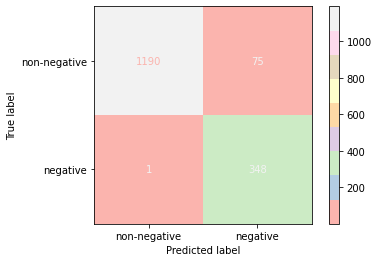

In [6]:
#KOR 5sec - feature selection(2) - under sampling(1/3) + SMOTE
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from numpy import array 
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
import warnings; warnings.filterwarnings(action='ignore') # 경고 메시지 무시
import matplotlib.pyplot as plt # 데이터 시각화 라이브러리
import pickle # 객체 입출력을 위한 라이브러리
from sklearn.model_selection import train_test_split # 훈련 데이터, 테스트 데이터 분리
from sklearn.preprocessing import StandardScaler # 정규화
from sklearn.ensemble import RandomForestClassifier as RFC # 랜덤포레스트 분류 알고리즘
from sklearn.tree import DecisionTreeClassifier as DTC # 의사결정나무 분류 알고리즘
from sklearn.ensemble import GradientBoostingClassifier as GBC # 그래디언트 부스팅 분류 알고리즘
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_moons
from sklearn.feature_selection import SelectFromModel
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import joblib
########################

UnderSampling = 1       # 1 : undersampling(size->1/3), 2 : undersampling(size->minority),   0 : not undersampling    
OverSampling = 1        # 1 : oversampling(SMOTE),                                           0 : not oversampling
selection = 2           # 1 : feature selection - RFEVC, 2 : feature selection - mutual information, 0 : not feature selection
feat_start=1
########################
data = pd.read_csv('/Users/jun/Data/sentiment analysis - KOR/5초전데이터/sentiment+gamedata/KOR-5sec(fin).csv')
scaler = StandardScaler()
y = data['sentiment']
X = data.drop(labels=['sentiment','file','time'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,random_state=7)
# 설명변수 데이터 스케일링
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
feature_name = X.columns
if UnderSampling == 1:
    undersample = RandomUnderSampler(sampling_strategy=0.827) 
    X_train, y_train = undersample.fit_resample(X_train, y_train)
elif UnderSampling == 2:
    undersample = RandomUnderSampler(sampling_strategy='majority') 
    X_train, y_train = undersample.fit_resample(X_train, y_train)
    
if OverSampling == 1:
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)
    
    
print(y_train.value_counts())

def modeling_uncustomized (algorithm, X_train, y_train, X_test, y_test):
    # 하이퍼파라미터 조정 없이 모델 학습
    uncustomized = algorithm(random_state=1234)
    uncustomized.fit(X_train, y_train)
    # Train Data 설명력
    train_score_before = uncustomized.score(X_train, y_train).round(3)
    print(f"학습 데이터셋 정확도: {train_score_before}")
    # Test Data 설명력
    test_score_before = uncustomized.score(X_test, y_test).round(3)
    print(f"테스트 데이터셋 정확도: {test_score_before}")
    return train_score_before, test_score_before


def optimi_visualization(algorithm_name, X_values, train_score, test_score, xlabel, filename):
    # 하이퍼파라미터 조정에 따른 학습 데이터셋 기반 모델 성능 추이 시각화
    plt.plot(X_values, train_score, linestyle = '-', label = 'train score')
    # 하이퍼파라미터 조정에 따른 테스트 데이터셋 기반 모델 성능 추이 시각화
    plt.plot(X_values, test_score, linestyle = '--', label = 'test score')
    plt.ylabel('Accuracy(%)') # y축 라벨
    plt.xlabel(xlabel) # x축 라벨
    plt.legend() # 범례표시
    
def optimi_estimator(algorithm, algorithm_name, X_train, y_train, X_test, y_test, n_estimator_min, n_estimator_max):
    train_score = []; test_score =[]
    para_n_tree = [n_tree*5 for n_tree in range(n_estimator_min, n_estimator_max)]

    for v_n_estimators in para_n_tree:
        model = algorithm(n_estimators = v_n_estimators, random_state=1234)
        model.fit(X_train, y_train)
        train_score.append(model.score(X_train, y_train))
        test_score.append(model.score(X_test, y_test))

    # 트리 개수에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'n_estimators': para_n_tree, 'TrainScore': train_score, 'TestScore': test_score})
    # 트리 개수에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_n_tree, train_score, test_score, "The number of estimator", "n_estimator")
    print(round(df_score_n, 4))


def optimi_maxdepth (algorithm, algorithm_name, X_train, y_train, X_test, y_test, depth_min, depth_max, n_estimator):
    train_score = []; test_score = []
    para_depth = [depth for depth in range(depth_min, depth_max)]

    for v_max_depth in para_depth:
        # 의사결정나무 모델의 경우 트리 개수를 따로 설정하지 않기 때문에 RFC, GBC와 분리하여 모델링
        if algorithm == DTC:
            model = algorithm(max_depth = v_max_depth,
                              random_state=1234)
        else:
            model = algorithm(max_depth = v_max_depth,
                              n_estimators = n_estimator,
                              random_state=1234)
        
        model.fit(X_train, y_train)
        train_score.append(model.score(X_train, y_train))
        test_score.append(model.score(X_test, y_test))

    # 최대 깊이에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'depth': para_depth, 'TrainScore': train_score, 'TestScore': test_score})
    # 최대 깊이에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_depth, train_score, test_score, "The number of depth", "n_depth")
    print(round(df_score_n, 4))
    
def optimi_minsplit (algorithm, algorithm_name, X_train, y_train, X_test, y_test, n_split_min, n_split_max, n_estimator, n_depth):
    train_score = []; test_score = []
    para_split = [n_split*2 for n_split in range(n_split_min, n_split_max)]
    for v_min_samples_split in para_split:
        # 의사결정나무 모델의 경우 트리 개수를 따로 설정하지 않기 때문에 RFC, GBC와 분리하여 모델링
        if algorithm == DTC:
            model = algorithm(min_samples_split = v_min_samples_split,
                              max_depth = n_depth,
                              random_state = 1234)
        else:
            model = algorithm(min_samples_split = v_min_samples_split,
                              n_estimators = n_estimator,
                              max_depth = n_depth,
                              random_state = 1234)
        model.fit(X_train, y_train)
        train_score.append(model.score(X_train, y_train))
        test_score.append(model.score(X_test, y_test))

    # 분리 노드의 최소 자료 수에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'min_samples_split': para_split, 'TrainScore': train_score, 'TestScore': test_score})
    # 분리 노드의 최소 자료 수에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_split, train_score, test_score, "The minimum number of samples required to split an internal node", "min_samples_split")
    print(round(df_score_n, 4))
    
def optimi_minleaf(algorithm, algorithm_name, X_train, y_train, X_test, y_test, n_leaf_min, n_leaf_max, n_estimator, n_depth, n_split):
    train_score = []; test_score = []
    para_leaf = [n_leaf*2 for n_leaf in range(n_leaf_min, n_leaf_max)]

    for v_min_samples_leaf in para_leaf:
        # 의사결정나무 모델의 경우 트리 개수를 따로 설정하지 않기 때문에 RFC, GBC와 분리하여 모델링
        if algorithm == DTC:
            model = algorithm(min_samples_leaf = v_min_samples_leaf,
                                        max_depth = n_depth,
                                        min_samples_split = n_split,
                                        random_state=1234)
        else:
            model = algorithm(min_samples_leaf = v_min_samples_leaf,
                                n_estimators = n_estimator,
                                max_depth = n_depth,
                                min_samples_split = n_split,
                                random_state=1234)
        model.fit(X_train, y_train)
        train_score.append(model.score(X_train, y_train))
        test_score.append(model.score(X_test, y_test))

    # 잎사귀 노드의 최소 자료 수에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'min_samples_leaf': para_leaf, 'TrainScore': train_score, 'TestScore': test_score})
    # 잎사귀 노드의 최소 자료 수에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_leaf, train_score, test_score, "The minimum number of samples required to be at a leaf node", "min_samples_leaf")
    print(round(df_score_n, 4))
    
def model_final(algorithm, algorithm_name, feature_name, X_train, y_train, X_test, y_test, n_estimator, n_depth, n_split, n_leaf, selection):
    # 의사결정나무 모델의 경우 트리 개수를 따로 설정하지 않기 때문에 RFC, GBC와 분리하여 모델링
    if algorithm == DTC:
        model = algorithm(random_state=1234, 
                          min_samples_leaf = n_leaf,
                          min_samples_split = n_split, 
                          max_depth = n_depth)
    else:
        model = algorithm(random_state = 1234, 
                          n_estimators = n_estimator, 
                          min_samples_leaf = n_leaf,
                          min_samples_split = n_split, 
                          max_depth = n_depth)
    
    if selection == 1 :
        selector = RFECV(model, min_features_to_select=5, step=1, cv = 5)
        selector.fit(X_train, y_train)
        selected_columns = X.columns[selector.support_]

        print(selected_columns)
        train_acc = selector.score(X_train, y_train)
        test_acc = selector.score(X_test, y_test)
        y_pred = selector.predict(X_test)
        roc_auc = metrics.roc_auc_score(y_test, selector.predict_proba(X_test)[:,1])
        print('AUC: {}'.format(roc_auc))
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}") # 정확도
        print(f"Precision: {precision_score(y_test, y_pred):.3f}") # 정밀도
        print(f"Recall: {recall_score(y_test, y_pred):.3f}") # 재현율
        print(f"F1-score: {f1_score(y_test, y_pred):.3f}") # F1 스코어

        # 혼동행렬 시각화
#         plt.figure(figsize =(40, 40))
#         plot_confusion_matrix(model, X_test, y_test,include_values = True,display_labels = ['non-negative', 'negative'],cmap = 'Pastel1') # 컬러맵
#         plt.show()

        # 변수 중요도 산출
        dt_importance = pd.DataFrame()
        dt_importance['Feature'] = feature_name # 설명변수 이름
        dt_importance['Rank'] = selector.ranking_ # 설명변수 중요도 산출

        # 변수 중요도 내림차순 정렬
        dt_importance.sort_values("Rank", ascending = False, inplace = True)
        print(dt_importance.round(3))
        # 변수 중요도 오름차순 정렬
        dt_importance.sort_values("Rank", ascending = True, inplace = True)
        # 변수 중요도 시각화
        coordinates = range(len(dt_importance)) # 설명변수 개수만큼 bar 시각화
        plt.barh(y = coordinates, width = dt_importance["Rank"])
        plt.yticks(coordinates, dt_importance["Feature"]) # y축 눈금별 설명변수 이름 기입
        plt.xlabel("Feature Rank") # x축 이름
        plt.ylabel("Features") # y축 이름
    elif selection == 2:
        mi_score = mutual_info_classif(X,y)
        print(mi_score)
        selector = SelectKBest(mutual_info_classif, k=7)
        selector.fit(X_train, y_train)
        X_train = selector.transform(X_train)
        X_test = selector.transform(X_test)
        filter = selector.get_support()
        features = array(feature_name)
        print(features[filter])
        model.fit(X_train, y_train)
        joblib.dump(model, '/Users/jun/Desktop/prof/Planned speech 2.0/gradient_KOR_model.pkl')
        score=selector.scores_
        
        train_acc = model.score(X_train, y_train)
        test_acc = model.score(X_test, y_test)
        y_pred = model.predict(X_test)
        roc_auc = metrics.roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
        print('AUC: {}'.format(roc_auc))
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}") # 정확도
        print(f"Precision: {precision_score(y_test, y_pred):.3f}") # 정밀도
        print(f"Recall: {recall_score(y_test, y_pred):.3f}") # 재현율
        print(f"F1-score: {f1_score(y_test, y_pred):.3f}") # F1 스코어

        # 혼동행렬 시각화
        plt.figure(figsize =(40, 40))
        plot_confusion_matrix(model, X_test, y_test,include_values = True,display_labels = ['non-negative', 'negative'],cmap = 'Pastel1') # 컬러맵
        plt.show()
    else:
        model.fit(X_train, y_train)
    
    
        # 최종 모델의 성능 평가
        train_acc = model.score(X_train, y_train)
        test_acc = model.score(X_test, y_test)
        y_pred = model.predict(X_test)
        roc_auc = metrics.roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
        print('AUC: {}'.format(roc_auc))
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}") # 정확도
        print(f"Precision: {precision_score(y_test, y_pred):.3f}") # 정밀도
        print(f"Recall: {recall_score(y_test, y_pred):.3f}") # 재현율
        print(f"F1-score: {f1_score(y_test, y_pred):.3f}") # F1 스코어

        # 혼동행렬 시각화
        plt.figure(figsize =(40, 40))
        plot_confusion_matrix(model, X_test, y_test,include_values = True,display_labels = ['non-negative', 'negative'],cmap = 'Pastel1') # 컬러맵
        plt.show()

        # 변수 중요도 산출
        dt_importance = pd.DataFrame()
        dt_importance['Feature'] = feature_name # 설명변수 이름
        dt_importance['Importance'] = model.feature_importances_ # 설명변수 중요도 산출

        # 변수 중요도 내림차순 정렬
        dt_importance.sort_values("Importance", ascending = False, inplace = True)
        print(dt_importance.round(3))
        # 변수 중요도 오름차순 정렬
        dt_importance.sort_values("Importance", ascending = True, inplace = True)
        # 변수 중요도 시각화
        coordinates = range(len(dt_importance)) # 설명변수 개수만큼 bar 시각화
        plt.barh(y = coordinates, width = dt_importance["Importance"])
        plt.yticks(coordinates, dt_importance["Feature"]) # y축 눈금별 설명변수 이름 기입
        plt.xlabel("Feature Importance") # x축 이름
        plt.ylabel("Features") # y축 이름
        
    

algorithm = GBC
algorithm_name = 'gbc'
train_acc_before, test_acc_before = modeling_uncustomized(algorithm, 
                                                          X_train,
                                                          y_train,
                                                          X_test,
                                                          y_test)

n_estimator = 135
n_depth = 12
n_split = 26
n_leaf = 22

model_final(algorithm, algorithm_name, feature_name,
            X_train, y_train, X_test, y_test,
            n_estimator, n_depth, n_split, n_leaf,selection)

0    4460
1    4460
Name: sentiment, dtype: int64
학습 데이터셋 정확도: 0.871
테스트 데이터셋 정확도: 0.801
[0.03633934 0.00010921 0.01844757 0.0199874  0.04749473 0.06361859
 0.06526177 0.00276064 0.00222304 0.         0.00120885 0.
 0.00207609 0.00367718 0.00111057 0.00208687 0.02123934 0.00392515
 0.00463629 0.00797484 0.00576925 0.00791244]
['Game_Runtime' 'Hunger_PLAYER' 'Health_PLAYER' 'Sanity_PLAYER'
 'Player_Xloc' 'Player_Zloc' 'Curr_Inv_Cnt_PLAYER']
AUC: 0.971608298927134
Accuracy: 0.958
Precision: 0.569
Recall: 0.884
F1-score: 0.693


<Figure size 2880x2880 with 0 Axes>

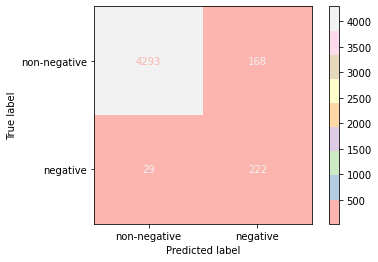

In [5]:
#ENG 5sec - feature selection(2) - under sampling(1/3) + SMOTE
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from numpy import array 
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
import warnings; warnings.filterwarnings(action='ignore') # 경고 메시지 무시
import matplotlib.pyplot as plt # 데이터 시각화 라이브러리
import pickle # 객체 입출력을 위한 라이브러리
from sklearn.model_selection import train_test_split # 훈련 데이터, 테스트 데이터 분리
from sklearn.preprocessing import StandardScaler # 정규화
from sklearn.ensemble import RandomForestClassifier as RFC # 랜덤포레스트 분류 알고리즘
from sklearn.tree import DecisionTreeClassifier as DTC # 의사결정나무 분류 알고리즘
from sklearn.ensemble import GradientBoostingClassifier as GBC # 그래디언트 부스팅 분류 알고리즘
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_moons
from sklearn.feature_selection import SelectFromModel
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import joblib
########################

UnderSampling = 1       # 1 : undersampling(size->1/3), 2 : undersampling(size->minority),   0 : not undersampling    
OverSampling = 1        # 1 : oversampling(SMOTE),                                           0 : not oversampling
selection = 2           # 1 : feature selection - RFEVC, 2 : feature selection - mutual information, 0 : not feature selection
feat_start=1
########################
data = pd.read_csv('/Users/jun/Data/sentiment analysis - ENG/5초전/사용할 파일/sentiment+gamedata/ENG-5sec(fin).csv')
scaler = StandardScaler()
y = data['sentiment']
X = data.drop(labels=['sentiment','file','time'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,random_state=7)
# 설명변수 데이터 스케일링
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
feature_name = X.columns
if UnderSampling == 1:
    undersample = RandomUnderSampler(sampling_strategy=0.1686) 
    X_train, y_train = undersample.fit_resample(X_train, y_train)
elif UnderSampling == 2:
    undersample = RandomUnderSampler(sampling_strategy='majority') 
    X_train, y_train = undersample.fit_resample(X_train, y_train)
    
if OverSampling == 1:
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)
    
    
print(y_train.value_counts())

def modeling_uncustomized (algorithm, X_train, y_train, X_test, y_test):
    # 하이퍼파라미터 조정 없이 모델 학습
    uncustomized = algorithm(random_state=1234)
    uncustomized.fit(X_train, y_train)
    # Train Data 설명력
    train_score_before = uncustomized.score(X_train, y_train).round(3)
    print(f"학습 데이터셋 정확도: {train_score_before}")
    # Test Data 설명력
    test_score_before = uncustomized.score(X_test, y_test).round(3)
    print(f"테스트 데이터셋 정확도: {test_score_before}")
    return train_score_before, test_score_before


def optimi_visualization(algorithm_name, X_values, train_score, test_score, xlabel, filename):
    # 하이퍼파라미터 조정에 따른 학습 데이터셋 기반 모델 성능 추이 시각화
    plt.plot(X_values, train_score, linestyle = '-', label = 'train score')
    # 하이퍼파라미터 조정에 따른 테스트 데이터셋 기반 모델 성능 추이 시각화
    plt.plot(X_values, test_score, linestyle = '--', label = 'test score')
    plt.ylabel('Accuracy(%)') # y축 라벨
    plt.xlabel(xlabel) # x축 라벨
    plt.legend() # 범례표시
    
def optimi_estimator(algorithm, algorithm_name, X_train, y_train, X_test, y_test, n_estimator_min, n_estimator_max):
    train_score = []; test_score =[]
    para_n_tree = [n_tree*5 for n_tree in range(n_estimator_min, n_estimator_max)]

    for v_n_estimators in para_n_tree:
        model = algorithm(n_estimators = v_n_estimators, random_state=1234)
        model.fit(X_train, y_train)
        train_score.append(model.score(X_train, y_train))
        test_score.append(model.score(X_test, y_test))

    # 트리 개수에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'n_estimators': para_n_tree, 'TrainScore': train_score, 'TestScore': test_score})
    # 트리 개수에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_n_tree, train_score, test_score, "The number of estimator", "n_estimator")
    print(round(df_score_n, 4))


def optimi_maxdepth (algorithm, algorithm_name, X_train, y_train, X_test, y_test, depth_min, depth_max, n_estimator):
    train_score = []; test_score = []
    para_depth = [depth for depth in range(depth_min, depth_max)]

    for v_max_depth in para_depth:
        # 의사결정나무 모델의 경우 트리 개수를 따로 설정하지 않기 때문에 RFC, GBC와 분리하여 모델링
        if algorithm == DTC:
            model = algorithm(max_depth = v_max_depth,
                              random_state=1234)
        else:
            model = algorithm(max_depth = v_max_depth,
                              n_estimators = n_estimator,
                              random_state=1234)
        
        model.fit(X_train, y_train)
        train_score.append(model.score(X_train, y_train))
        test_score.append(model.score(X_test, y_test))

    # 최대 깊이에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'depth': para_depth, 'TrainScore': train_score, 'TestScore': test_score})
    # 최대 깊이에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_depth, train_score, test_score, "The number of depth", "n_depth")
    print(round(df_score_n, 4))
    
def optimi_minsplit (algorithm, algorithm_name, X_train, y_train, X_test, y_test, n_split_min, n_split_max, n_estimator, n_depth):
    train_score = []; test_score = []
    para_split = [n_split*2 for n_split in range(n_split_min, n_split_max)]
    for v_min_samples_split in para_split:
        # 의사결정나무 모델의 경우 트리 개수를 따로 설정하지 않기 때문에 RFC, GBC와 분리하여 모델링
        if algorithm == DTC:
            model = algorithm(min_samples_split = v_min_samples_split,
                              max_depth = n_depth,
                              random_state = 1234)
        else:
            model = algorithm(min_samples_split = v_min_samples_split,
                              n_estimators = n_estimator,
                              max_depth = n_depth,
                              random_state = 1234)
        model.fit(X_train, y_train)
        train_score.append(model.score(X_train, y_train))
        test_score.append(model.score(X_test, y_test))

    # 분리 노드의 최소 자료 수에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'min_samples_split': para_split, 'TrainScore': train_score, 'TestScore': test_score})
    # 분리 노드의 최소 자료 수에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_split, train_score, test_score, "The minimum number of samples required to split an internal node", "min_samples_split")
    print(round(df_score_n, 4))
    
def optimi_minleaf(algorithm, algorithm_name, X_train, y_train, X_test, y_test, n_leaf_min, n_leaf_max, n_estimator, n_depth, n_split):
    train_score = []; test_score = []
    para_leaf = [n_leaf*2 for n_leaf in range(n_leaf_min, n_leaf_max)]

    for v_min_samples_leaf in para_leaf:
        # 의사결정나무 모델의 경우 트리 개수를 따로 설정하지 않기 때문에 RFC, GBC와 분리하여 모델링
        if algorithm == DTC:
            model = algorithm(min_samples_leaf = v_min_samples_leaf,
                                        max_depth = n_depth,
                                        min_samples_split = n_split,
                                        random_state=1234)
        else:
            model = algorithm(min_samples_leaf = v_min_samples_leaf,
                                n_estimators = n_estimator,
                                max_depth = n_depth,
                                min_samples_split = n_split,
                                random_state=1234)
        model.fit(X_train, y_train)
        train_score.append(model.score(X_train, y_train))
        test_score.append(model.score(X_test, y_test))

    # 잎사귀 노드의 최소 자료 수에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'min_samples_leaf': para_leaf, 'TrainScore': train_score, 'TestScore': test_score})
    # 잎사귀 노드의 최소 자료 수에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_leaf, train_score, test_score, "The minimum number of samples required to be at a leaf node", "min_samples_leaf")
    print(round(df_score_n, 4))
    
def model_final(algorithm, algorithm_name, feature_name, X_train, y_train, X_test, y_test, n_estimator, n_depth, n_split, n_leaf, selection):
    # 의사결정나무 모델의 경우 트리 개수를 따로 설정하지 않기 때문에 RFC, GBC와 분리하여 모델링
    if algorithm == DTC:
        model = algorithm(random_state=1234, 
                          min_samples_leaf = n_leaf,
                          min_samples_split = n_split, 
                          max_depth = n_depth)
    else:
        model = algorithm(random_state = 1234, 
                          n_estimators = n_estimator, 
                          min_samples_leaf = n_leaf,
                          min_samples_split = n_split, 
                          max_depth = n_depth)
    
    if selection == 1 :
        selector = RFECV(model, min_features_to_select=5, step=1, cv = 5)
        selector.fit(X_train, y_train)
        selected_columns = X.columns[selector.support_]

        print(selected_columns)
        train_acc = selector.score(X_train, y_train)
        test_acc = selector.score(X_test, y_test)
        y_pred = selector.predict(X_test)
        roc_auc = metrics.roc_auc_score(y_test, selector.predict_proba(X_test)[:,1])
        print('AUC: {}'.format(roc_auc))
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}") # 정확도
        print(f"Precision: {precision_score(y_test, y_pred):.3f}") # 정밀도
        print(f"Recall: {recall_score(y_test, y_pred):.3f}") # 재현율
        print(f"F1-score: {f1_score(y_test, y_pred):.3f}") # F1 스코어

        # 혼동행렬 시각화
#         plt.figure(figsize =(40, 40))
#         plot_confusion_matrix(model, X_test, y_test,include_values = True,display_labels = ['non-negative', 'negative'],cmap = 'Pastel1') # 컬러맵
#         plt.show()

        # 변수 중요도 산출
        dt_importance = pd.DataFrame()
        dt_importance['Feature'] = feature_name # 설명변수 이름
        dt_importance['Rank'] = selector.ranking_ # 설명변수 중요도 산출

        # 변수 중요도 내림차순 정렬
        dt_importance.sort_values("Rank", ascending = False, inplace = True)
        print(dt_importance.round(3))
        # 변수 중요도 오름차순 정렬
        dt_importance.sort_values("Rank", ascending = True, inplace = True)
        # 변수 중요도 시각화
        coordinates = range(len(dt_importance)) # 설명변수 개수만큼 bar 시각화
        plt.barh(y = coordinates, width = dt_importance["Rank"])
        plt.yticks(coordinates, dt_importance["Feature"]) # y축 눈금별 설명변수 이름 기입
        plt.xlabel("Feature Rank") # x축 이름
        plt.ylabel("Features") # y축 이름
    elif selection == 2:
        mi_score = mutual_info_classif(X,y)
        print(mi_score)
        selector = SelectKBest(mutual_info_classif, k=7)
        selector.fit(X_train, y_train)
        X_train = selector.transform(X_train)
        X_test = selector.transform(X_test)
        filter = selector.get_support()
        features = array(feature_name)
        print(features[filter])
        model.fit(X_train, y_train)
    
        joblib.dump(model, '/Users/jun/Desktop/prof/Planned speech 2.0/gradient_ENG_model.pkl') 
        score=selector.scores_
        
        train_acc = model.score(X_train, y_train)
        test_acc = model.score(X_test, y_test)
        y_pred = model.predict(X_test)
        roc_auc = metrics.roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
        print('AUC: {}'.format(roc_auc))
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}") # 정확도
        print(f"Precision: {precision_score(y_test, y_pred):.3f}") # 정밀도
        print(f"Recall: {recall_score(y_test, y_pred):.3f}") # 재현율
        print(f"F1-score: {f1_score(y_test, y_pred):.3f}") # F1 스코어

        # 혼동행렬 시각화
        plt.figure(figsize =(40, 40))
        plot_confusion_matrix(model, X_test, y_test,include_values = True,display_labels = ['non-negative', 'negative'],cmap = 'Pastel1') # 컬러맵
        plt.show()
    else:
        model.fit(X_train, y_train)
    
    
        # 최종 모델의 성능 평가
        train_acc = model.score(X_train, y_train)
        test_acc = model.score(X_test, y_test)
        y_pred = model.predict(X_test)
        roc_auc = metrics.roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
        print('AUC: {}'.format(roc_auc))
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}") # 정확도
        print(f"Precision: {precision_score(y_test, y_pred):.3f}") # 정밀도
        print(f"Recall: {recall_score(y_test, y_pred):.3f}") # 재현율
        print(f"F1-score: {f1_score(y_test, y_pred):.3f}") # F1 스코어

        # 혼동행렬 시각화
        plt.figure(figsize =(40, 40))
        plot_confusion_matrix(model, X_test, y_test,include_values = True,display_labels = ['non-negative', 'negative'],cmap = 'Pastel1') # 컬러맵
        plt.show()

        # 변수 중요도 산출
        dt_importance = pd.DataFrame()
        dt_importance['Feature'] = feature_name # 설명변수 이름
        dt_importance['Importance'] = model.feature_importances_ # 설명변수 중요도 산출

        # 변수 중요도 내림차순 정렬
        dt_importance.sort_values("Importance", ascending = False, inplace = True)
        print(dt_importance.round(3))
        # 변수 중요도 오름차순 정렬
        dt_importance.sort_values("Importance", ascending = True, inplace = True)
        # 변수 중요도 시각화
        coordinates = range(len(dt_importance)) # 설명변수 개수만큼 bar 시각화
        plt.barh(y = coordinates, width = dt_importance["Importance"])
        plt.yticks(coordinates, dt_importance["Feature"]) # y축 눈금별 설명변수 이름 기입
        plt.xlabel("Feature Importance") # x축 이름
        plt.ylabel("Features") # y축 이름
        
    

algorithm = GBC
algorithm_name = 'gbc'
train_acc_before, test_acc_before = modeling_uncustomized(algorithm, 
                                                          X_train,
                                                          y_train,
                                                          X_test,
                                                          y_test)

n_estimator = 150
n_depth = 11
n_split = 112
n_leaf = 12

model_final(algorithm, algorithm_name, feature_name,
            X_train, y_train, X_test, y_test,
            n_estimator, n_depth, n_split, n_leaf,selection)